<a href="https://colab.research.google.com/github/karthikmswamy/TF_Intro_Notebooks/blob/master/TF_DF_with_Data_Variations_Bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs

In [ ]:
# !pip install -U augly
# !sudo apt-get install python3-magic
!pip install tensorflow_decision_forests
!pip install wurlitzer

## Imports

In [5]:
from time import time

import tensorflow_decision_forests as tfdf
import pandas as pd
import tensorflow as tf
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
import matplotlib.pyplot as plt

## Data Download and Check

In [ ]:
! wget -O bank.zip "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip" 

! unzip bank.zip

In [7]:
# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("./bank-additional/bank-additional-full.csv", delimiter=';')

# Display the first 3 examples.
dataset_df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [9]:
# Name of the label column.
label = "y"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: ['no', 'yes']


In [10]:
print(f"Number of records: {len(dataset_df)}")

Number of records: 41188


## Helper Methods

In [11]:
# Split the dataset into a training and a testing dataset.
# Test split remains a constant 
def split_dataset(dataset, num_train=10000):
  """Splits a panda dataframe in two."""
  dataset = dataset.sample(frac=1.0, random_state=1729)
  
  test_dataset = dataset[35000:]
  train_dataset = dataset[:num_train]
  
  return train_dataset, test_dataset

In [12]:
def train_rf_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)

    # Specify the model.
    model_1 = tfdf.keras.RandomForestModel(num_trees=30)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["accuracy"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds)

    # print(f"Loss: {evaluation[0]}")
    print(f"Accuracy: {evaluation[1]} in {time() - t1} secs")
    return evaluation[1], time() - t1

In [13]:
def train_gbdt_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)

    # Specify the model.
    model_1 = tfdf.keras.GradientBoostedTreesModel(num_trees=30)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["accuracy"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds)

    # print(f"Loss: {evaluation[0]}")
    print(f"Accuracy: {evaluation[1]} in {time() - t1} secs")
    return evaluation[1], time() - t1

In [14]:
def train_cart_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)

    # Specify the model.
    model_1 = tfdf.keras.CartModel()

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["accuracy"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds)

    # print(f"Loss: {evaluation[0]}")
    print(f"Accuracy: {evaluation[1]} in {time() - t1} secs")
    return evaluation[1], time() - t1

## Train with Different Records

In [15]:
def train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm):
    train_ds_pd, test_ds_pd = split_dataset(dataset_df, num_train)
    print(f"{len(train_ds_pd)} examples in training, {len(test_ds_pd)} examples for testing.")

    accuracy, time_taken = train_rf_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_rf.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_gbdt_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_gb.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_cart_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_cm.append([num_train, accuracy, time_taken])

    return results_rf, results_gb, results_cm

In [16]:
results_rf, results_gb, results_cm = [], [], []
num_train_list = [5000, 10000, 15000, 20000, 25000, 30000, 35000]
for num_train in num_train_list:
    results_rf, results_gb, results_cm = train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm)

5000 examples in training, 6188 examples for testing.


2021-07-31 12:57:15.934815: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-31 12:57:15.945197: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz


79/79 [==============================] - 5s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 79
[INFO kernel.cc:393] Number of examples: 5000
[INFO kernel.cc:769] Dataset:
Number of records: 5000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 3191 (63.82%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"fri" 1039 (20.78%)
	6: "default" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"no" 3982 (79.64%)
	8: "education" CATEGORICAL has-dict vocab-size:8 zero-ood-items most-frequent:"university.degree" 1463 (29.26%)
	11: "housing" CATEGORICAL has-dict vocab-size:4 zero-ood-items most-frequent:"yes" 2654 (53.08%)
	12: "job" CATEGORICAL has-dict vocab-size:13 zero-ood-items most-frequent:"admin." 1305 (26.1%)
	13: "loan" 

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9003
Accuracy: 0.9002909064292908 in 9.522307872772217 secs
79/79 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 79
[INFO kernel.cc:393] Number of examples: 5000
[INFO kernel.cc:769] Dataset:
Number of records: 5000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 3191 (63.82%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"fri" 1039 (20.78%)
	6: "default" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"no" 3982 (79.64%)
	8: "education" CATEGORICAL has-dict vocab-size:8 zero-ood-items most-frequent:"university.degree" 1463 (29.26%)
	11: "housing" CATEGORICAL has-dict vocab-size:4 zero-ood-items most-frequent:"yes" 2654 (53.08%)
	12: "job" CATEGORICAL has-dict vocab-size:13 zero-ood-items most-frequent:"admin." 1305 (26.1%)
	13: "loan" 

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9034
Accuracy: 0.9033613204956055 in 1.8430182933807373 secs
79/79 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 79
[INFO kernel.cc:393] Number of examples: 5000
[INFO kernel.cc:769] Dataset:
Number of records: 5000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 3191 (63.82%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"fri" 1039 (20.78%)
	6: "default" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"no" 3982 (79.64%)
	8: "education" CATEGORICAL has-dict vocab-size:8 zero-ood-items most-frequent:"university.degree" 1463 (29.26%)
	11: "housing" CATEGORICAL has-dict vocab-size:4 zero-ood-items most-frequent:"yes" 2654 (53.08%)
	12: "job" CATEGORICAL has-dict vocab-size:13 zero-ood-items most-frequent:"admin." 1305 (26.1%)
	13: "loan" 

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8974
Accuracy: 0.8973820209503174 in 1.540806770324707 secs
10000 examples in training, 6188 examples for testing.
157/157 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 157
[INFO kernel.cc:393] Number of examples: 10000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column education (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 10000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 6363 (63.63%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"mon" 2125 (2

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9092
Accuracy: 0.9091790318489075 in 2.156569004058838 secs
157/157 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 157
[INFO kernel.cc:393] Number of examples: 10000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column education (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 10000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 6363 (63.63%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"mon" 2125 (2

97/97 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9084
Accuracy: 0.9083710312843323 in 2.3952243328094482 secs
157/157 [==============================] - 1s 3ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 157
[INFO kernel.cc:393] Number of examples: 10000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column education (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 10000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 6363 (63.63%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"mon" 2125 (2

97/97 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9026
Accuracy: 0.9025533199310303 in 1.7638566493988037 secs
15000 examples in training, 6188 examples for testing.
235/235 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 235
[INFO kernel.cc:393] Number of examples: 15000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 15000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 9537 (63.58%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"mon" 3190 (21.2667%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.00666667%) most-frequent:"no" 11898 (79.32%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.degr

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9074
Accuracy: 0.907401442527771 in 2.8663649559020996 secs
235/235 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 235
[INFO kernel.cc:393] Number of examples: 15000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 15000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 9537 (63.58%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"mon" 3190 (21.2667%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.00666667%) most-frequent:"no" 11898 (79.32%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.degr

97/97 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9119
Accuracy: 0.9119263291358948 in 2.3906939029693604 secs
235/235 [==============================] - 1s 3ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 235
[INFO kernel.cc:393] Number of examples: 15000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 15000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 9537 (63.58%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"mon" 3190 (21.2667%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.00666667%) most-frequent:"no" 11898 (79.32%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.degr

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9059
Accuracy: 0.9059469699859619 in 2.3959898948669434 secs
20000 examples in training, 6188 examples for testing.
313/313 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 313
[INFO kernel.cc:393] Number of examples: 20000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 20000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 12733 (63.665%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"mon" 4228 (21.14%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.005%) most-frequent:"no" 15846 (79.23%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.degree" 5

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9132
Accuracy: 0.913219153881073 in 3.9889543056488037 secs
313/313 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 313
[INFO kernel.cc:393] Number of examples: 20000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 20000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 12733 (63.665%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"mon" 4228 (21.14%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.005%) most-frequent:"no" 15846 (79.23%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.degree" 5

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9148
Accuracy: 0.9148351550102234 in 3.678718090057373 secs
313/313 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 313
[INFO kernel.cc:393] Number of examples: 20000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 20000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 12733 (63.665%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"mon" 4228 (21.14%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.005%) most-frequent:"no" 15846 (79.23%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.degree" 5

97/97 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9084
Accuracy: 0.9083710312843323 in 2.435849666595459 secs
25000 examples in training, 6188 examples for testing.
391/391 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 391
[INFO kernel.cc:393] Number of examples: 25000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 25000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 15892 (63.568%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"thu" 5227 (20.908%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.004%) most-frequent:"no" 19793 (79.172%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.degree"

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9118
Accuracy: 0.9117646813392639 in 3.5691325664520264 secs
391/391 [==============================] - 1s 3ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 391
[INFO kernel.cc:393] Number of examples: 25000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 25000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 15892 (63.568%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"thu" 5227 (20.908%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.004%) most-frequent:"no" 19793 (79.172%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.degree"

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9148
Accuracy: 0.9148351550102234 in 3.6832005977630615 secs
391/391 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 391
[INFO kernel.cc:393] Number of examples: 25000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 25000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 15892 (63.568%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"thu" 5227 (20.908%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.004%) most-frequent:"no" 19793 (79.172%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.degree"

97/97 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9048
Accuracy: 0.9048157930374146 in 2.35990834236145 secs
30000 examples in training, 6188 examples for testing.
469/469 [==============================] - 2s 3ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 469
[INFO kernel.cc:393] Number of examples: 30000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 30000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 19033 (63.4433%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"thu" 6251 (20.8367%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.00333333%) most-frequent:"no" 23706 (79.02%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.d

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9124
Accuracy: 0.912411093711853 in 4.446872234344482 secs
469/469 [==============================] - 1s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 469
[INFO kernel.cc:393] Number of examples: 30000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 30000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 19033 (63.4433%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"thu" 6251 (20.8367%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.00333333%) most-frequent:"no" 23706 (79.02%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.d

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9169
Accuracy: 0.9169359803199768 in 3.4049160480499268 secs
469/469 [==============================] - 1s 3ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 469
[INFO kernel.cc:393] Number of examples: 30000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 30000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 19033 (63.4433%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"thu" 6251 (20.8367%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.00333333%) most-frequent:"no" 23706 (79.02%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university.d

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9043
Accuracy: 0.9043309688568115 in 3.7512710094451904 secs
35000 examples in training, 6188 examples for testing.
547/547 [==============================] - 2s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 547
[INFO kernel.cc:393] Number of examples: 35000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 35000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 22224 (63.4971%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"thu" 7302 (20.8629%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.00285714%) most-frequent:"no" 27687 (79.1057%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9110
Accuracy: 0.9109566807746887 in 4.6606125831604 secs
547/547 [==============================] - 2s 3ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 547
[INFO kernel.cc:393] Number of examples: 35000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 35000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 22224 (63.4971%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"thu" 7302 (20.8629%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.00285714%) most-frequent:"no" 27687 (79.1057%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9176
Accuracy: 0.9175823926925659 in 3.933616876602173 secs
547/547 [==============================] - 2s 3ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 547
[INFO kernel.cc:393] Number of examples: 35000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column default (2 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 35000
Number of columns: 21

Number of columns by type:
	CATEGORICAL: 11 (52.381%)
	NUMERICAL: 10 (47.619%)

Columns:

CATEGORICAL: 11 (52.381%)
	4: "contact" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"cellular" 22224 (63.4971%)
	5: "day_of_week" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"thu" 7302 (20.8629%)
	6: "default" CATEGORICAL has-dict vocab-size:3 num-oods:1 (0.00285714%) most-frequent:"no" 27687 (79.1057%)
	8: "education" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"university

97/97 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9085
Accuracy: 0.9085326194763184 in 3.757331371307373 secs


## Plotting Results

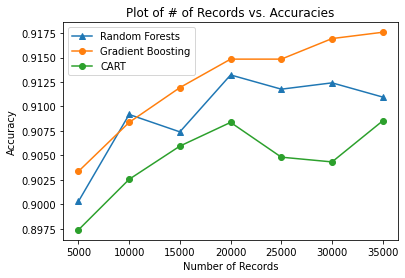

In [17]:
x  = [res[0] for res in results_rf]
y1 = [res[1] for res in results_rf]
y2 = [res[1] for res in results_gb]
y3 = [res[1] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("Accuracy")
plt.title("Plot of # of Records vs. Accuracies")
plt.legend()
plt.show()

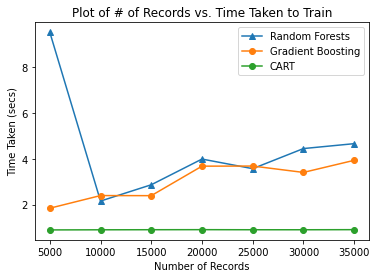

In [18]:
x  = [res[0] for res in results_rf]
y1 = [res[2] for res in results_rf]
y2 = [res[2] for res in results_gb]
y3 = [res[1] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("Time Taken (secs)")
plt.title("Plot of # of Records vs. Time Taken to Train")
plt.legend()
plt.show()